# Transferring Image Styles

This notebook provides you with a complete code example that loads the content image, the style image, and the VGG16 pre-trained neural network, and uses them to transfer the style to the image.

## Loading the Content and Style Images

Load a crop of the content image ...

This image is sourced from the Drosophila ssTEM dataset, which is publicly available on Figshare: [Segmented anisotropic ssTEM dataset of neural tissue](https://figshare.com/articles/dataset/Segmented_anisotropic_ssTEM_dataset_of_neural_tissue/856713). This dataset provides a detailed view of neural tissue, aiding in the study of neural structures and patterns. The image can also be downloaded from the corresponding GitHub repository at [this link](http://github.com/unidesigner/groundtruth-drosophila-vnc), which offers additional resources and information related to the Drosophila ssTEM dataset.

In [1]:
from PIL import Image

content = (
    Image.open("neuraltissue_with_colorlabels.png")
    .convert("RGB")
    .crop((100, 170, 100 + 256, 170 + 256)) 
)

... plot it ...

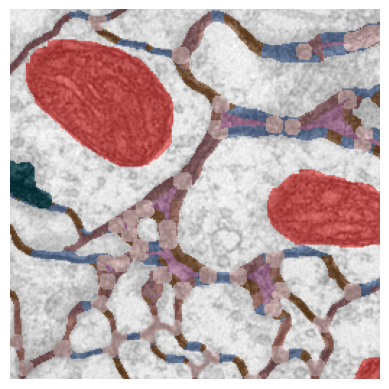

In [2]:
import matplotlib.pyplot as plt

plt.imshow(content)
plt.axis("off")
plt.show()

... load the style image ...

You'll use the style of the _trencadis_ lizard by Antoni Gaudi  in Parc Guell (Barcelona).

In [3]:
style = Image.open("lizard.png").convert("RGB").resize((256, 256))

... and plot it.

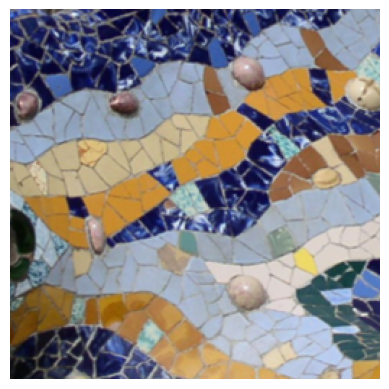

In [4]:
plt.imshow(style)
plt.axis("off")
plt.show()

## Loading a Pre-Trained Neural Network

In [5]:
from torchvision.models import vgg16, VGG16_Weights

model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
model.eval()
model.requires_grad_(False)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
import numpy as np
import torch

mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std = np.array([0.229, 0.224, 0.225], dtype=np.float32)

low = torch.tensor((- mean / std).reshape(1, -1, 1, 1))
high = torch.tensor(((1 - mean) / std).reshape(1, -1, 1, 1))

## Implementing Style Transfer

Implement a function to calculate the Gram matrix between all the activations of a specific layer ...

In [7]:
from torch import bmm

def gram(tensor):
    """Gram matrix."""
    batch_size, num_channels, height, width = tensor.size()
    features = tensor.view(batch_size, num_channels, height * width)
    gram_matrix = bmm(features, features.transpose(1, 2)) / (height * width)
    return gram_matrix

... define functions to to convert an image to a tensor, and vice versa ...

In [8]:
import torchvision.transforms as tt

def image_to_tensor(im, mean, std):
    """Convert image to tensor."""
    normalize = tt.Compose([tt.ToTensor(), tt.Normalize(mean, std)]) 
    return normalize(im).unsqueeze(0).requires_grad_(True)

def tensor_to_image(image, mean, std):
    """Convert tensor to image."""
    denormalize = tt.Normalize(mean=- mean / std, std=1 / std)
    im_array = denormalize(image.data.clone().detach().squeeze()).numpy() 
    im_array = np.clip(im_array.transpose(1, 2, 0) * 255, 0, 255)
    im_array = im_array.astype(np.uint8)
    return Image.fromarray(im_array, "RGB")

... define a context manager class ...

In [9]:
class Fwd_Hooks():
    """Forward hook."""
    
    def __init__(self, layers):
        """Initialize forward hooks."""
        self.hooks = []
        self.activations_list = []
        for layer in layers:
            self.hooks.append(layer.register_forward_hook(self.hook_func))
    
    def hook_func(self, layer, input, output):
        """Save activations."""
        self.activations_list.append(output)

    def __enter__(self, *args):
        """Enter context and register hooks."""
        return self

    def __exit__(self, *args):
        """Exit context management and remove hooks."""
        for hook in self.hooks:
            hook.remove()

... and define a function to implement style transfer.

In [10]:
def style_transfer(image, content, style, content_layers, style_layers,
                   lr=1, iter_num=100, beta=1e3):
    """Perform style transfer."""
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
    
    image_tensor = image_to_tensor(image, mean, std)
    
    with Fwd_Hooks(content_layers) as fh:
        _ = model(image_to_tensor(content, mean, std))
    content_activations = [activations.detach()
                           for activations in fh.activations_list]
    
    with Fwd_Hooks(style_layers) as fh:
        _ = model(image_to_tensor(style, mean, std))
    gram_targets = [gram(activations.detach())
                    for activations in fh.activations_list]

    optimizer = torch.optim.LBFGS([image_tensor], lr=lr) 
    mse_loss = torch.nn.MSELoss(reduction="sum")

    def closure():
        """Closure function for the optimizer.""" 
        optimizer.zero_grad()
        
        with Fwd_Hooks(content_layers) as fh:
            _ = model(image_tensor)
        image_content_activations = fh.activations_list
        
        content_loss = 0
        for ia, ca in zip(image_content_activations, content_activations):
            n_f = ia.shape[1]
            content_loss += mse_loss(ia, ca) / n_f ** 2
        content_loss /= len(image_content_activations)
        
        with Fwd_Hooks(style_layers) as fh:
            _ = model(image_tensor)
        gram_image = [gram(activations) for activations in fh.activations_list]

        style_loss = 0
        for gi, gt in zip(gram_image, gram_targets):
            n_g = gi.shape[1]
            style_loss += mse_loss(gi, gt) / n_g ** 2
        style_loss /= len(gram_image) 
        
        print(f"content_loss={content_loss} style_loss={style_loss}")

        total_loss = content_loss + beta * style_loss
        total_loss.backward()        
        return total_loss
    
    for i in range(iter_num):
        print(f"iteration {i}")
        optimizer.step(closure)
        
        image = tensor_to_image(image_tensor, mean, std)

        if i <= 5 or i % 10 == 0 or i == iter_num - 1:
            plt.imshow(image)
            plt.title(f"Iteration {i}")
            plt.axis("off")
            plt.show()
    
    return image

## Transferring the Style of an Image to Another Image

Starting from a random image ...

iteration 0
content_loss=330.2001953125 style_loss=229.17495727539062
content_loss=330.19830322265625 style_loss=229.16000366210938
content_loss=305.2281799316406 style_loss=85.80683898925781
content_loss=290.3660888671875 style_loss=49.35456085205078
content_loss=275.3670959472656 style_loss=23.804996490478516
content_loss=266.9533996582031 style_loss=12.487568855285645
content_loss=265.2117919921875 style_loss=6.950543403625488
content_loss=276.8855895996094 style_loss=4.247895240783691
content_loss=312.2485656738281 style_loss=2.660998582839966
content_loss=350.41693115234375 style_loss=1.8286678791046143
content_loss=342.08428955078125 style_loss=1.3937050104141235
content_loss=361.2183837890625 style_loss=1.0950828790664673
content_loss=346.09613037109375 style_loss=0.93365079164505
content_loss=348.2518615722656 style_loss=0.7843493223190308
content_loss=348.37652587890625 style_loss=0.6680420637130737
content_loss=340.80224609375 style_loss=0.5786512494087219
content_loss=345.09

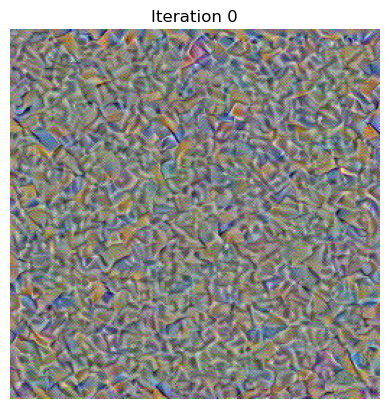

iteration 1
content_loss=328.1159362792969 style_loss=0.35563716292381287
content_loss=322.455322265625 style_loss=0.32339996099472046
content_loss=322.76605224609375 style_loss=0.28972527384757996
content_loss=309.8946838378906 style_loss=0.30090922117233276
content_loss=315.4549255371094 style_loss=0.26485294103622437
content_loss=315.2332763671875 style_loss=0.25183194875717163
content_loss=308.679931640625 style_loss=0.23989681899547577
content_loss=305.01043701171875 style_loss=0.22374308109283447
content_loss=303.38446044921875 style_loss=0.2077213078737259
content_loss=295.3465576171875 style_loss=0.20258641242980957
content_loss=296.4884338378906 style_loss=0.1865706741809845
content_loss=294.62542724609375 style_loss=0.1802404820919037
content_loss=283.99609375 style_loss=0.1833774298429489
content_loss=287.11199951171875 style_loss=0.16401314735412598
content_loss=285.188720703125 style_loss=0.16097678244113922
content_loss=275.468017578125 style_loss=0.16563363373279572
cont

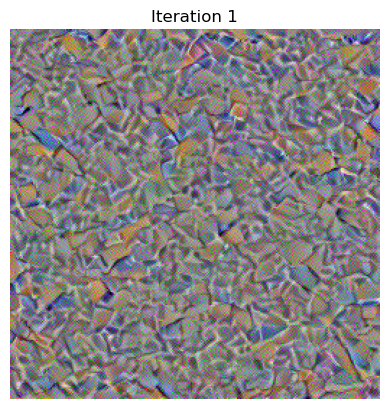

iteration 2
content_loss=268.71484375 style_loss=0.13307403028011322
content_loss=261.7266540527344 style_loss=0.13207009434700012
content_loss=262.44683837890625 style_loss=0.12292609363794327
content_loss=259.2579650878906 style_loss=0.12250570952892303
content_loss=255.50103759765625 style_loss=0.1205228716135025
content_loss=252.95639038085938 style_loss=0.11606891453266144
content_loss=250.73953247070312 style_loss=0.11196212470531464
content_loss=247.8032989501953 style_loss=0.11045406013727188
content_loss=246.12135314941406 style_loss=0.1064973846077919
content_loss=241.70925903320312 style_loss=0.10622632503509521
content_loss=239.13145446777344 style_loss=0.10294659435749054
content_loss=237.7897491455078 style_loss=0.09902450442314148
content_loss=231.96539306640625 style_loss=0.10283482074737549
content_loss=233.42515563964844 style_loss=0.0961463451385498
content_loss=232.11215209960938 style_loss=0.09496940672397614
content_loss=228.40306091308594 style_loss=0.09449575096

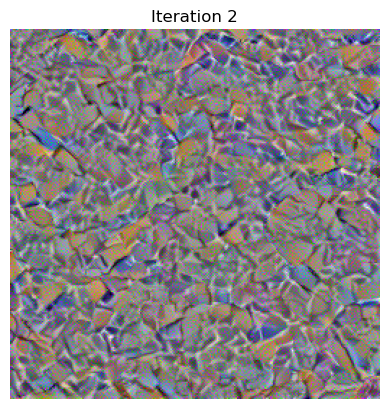

iteration 3
content_loss=220.41864013671875 style_loss=0.0858844742178917
content_loss=215.84130859375 style_loss=0.08692309260368347
content_loss=215.75360107421875 style_loss=0.08303976058959961
content_loss=213.71469116210938 style_loss=0.08291840553283691
content_loss=211.7410125732422 style_loss=0.08192090690135956
content_loss=209.9813690185547 style_loss=0.0803275853395462
content_loss=207.63479614257812 style_loss=0.0790390819311142
content_loss=205.42108154296875 style_loss=0.07784847915172577
content_loss=204.17324829101562 style_loss=0.07623539119958878
content_loss=202.95269775390625 style_loss=0.07543919235467911
content_loss=201.65350341796875 style_loss=0.07430693507194519
content_loss=198.28866577148438 style_loss=0.07521922886371613
content_loss=198.6963653564453 style_loss=0.0722203478217125
content_loss=197.14215087890625 style_loss=0.07182266563177109
content_loss=193.7501678466797 style_loss=0.07267586886882782
content_loss=194.22373962402344 style_loss=0.069629907

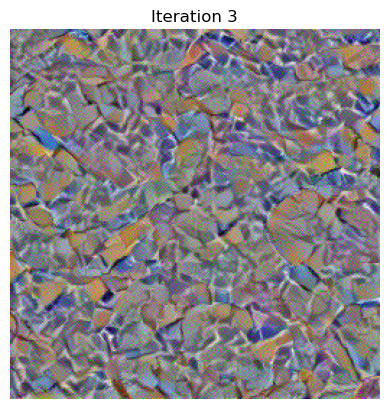

iteration 4
content_loss=187.01950073242188 style_loss=0.06730978190898895
content_loss=186.03118896484375 style_loss=0.06613703072071075
content_loss=184.9093475341797 style_loss=0.06491021066904068
content_loss=183.6431427001953 style_loss=0.0641767606139183
content_loss=181.37631225585938 style_loss=0.06427601724863052
content_loss=181.38528442382812 style_loss=0.06221423298120499
content_loss=179.0660400390625 style_loss=0.06244688481092453
content_loss=177.61532592773438 style_loss=0.06159336492419243
content_loss=175.9200439453125 style_loss=0.061582811176776886
content_loss=176.08682250976562 style_loss=0.059654951095581055
content_loss=174.43829345703125 style_loss=0.059995610266923904
content_loss=172.4420166015625 style_loss=0.0600762665271759
content_loss=171.7593994140625 style_loss=0.058640677481889725
content_loss=170.33172607421875 style_loss=0.058430444449186325
content_loss=169.83218383789062 style_loss=0.05721943825483322
content_loss=168.39425659179688 style_loss=0.0

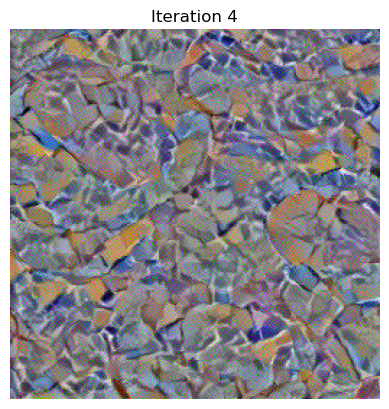

iteration 5
content_loss=162.46340942382812 style_loss=0.054843008518218994
content_loss=161.8260955810547 style_loss=0.053955357521772385
content_loss=160.55697631835938 style_loss=0.05382733419537544
content_loss=159.4005126953125 style_loss=0.05335070565342903
content_loss=158.51536560058594 style_loss=0.052577294409275055
content_loss=157.2537841796875 style_loss=0.05234348773956299
content_loss=156.38287353515625 style_loss=0.05186370760202408
content_loss=155.6527099609375 style_loss=0.05151062086224556
content_loss=154.5478973388672 style_loss=0.05128995701670647
content_loss=153.9503936767578 style_loss=0.05060611292719841
content_loss=152.12303161621094 style_loss=0.05128433555364609
content_loss=152.11566162109375 style_loss=0.049799855798482895
content_loss=150.84231567382812 style_loss=0.049922507256269455
content_loss=149.74673461914062 style_loss=0.04973609000444412
content_loss=149.15147399902344 style_loss=0.04908832162618637
content_loss=148.3309783935547 style_loss=0.

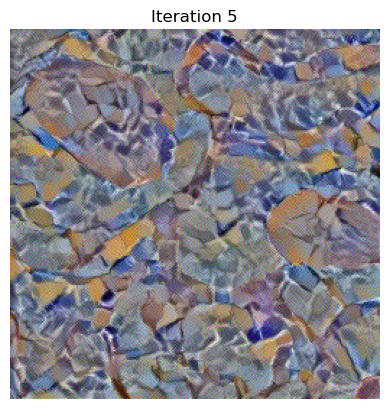

iteration 6
content_loss=144.17718505859375 style_loss=0.04788173735141754
content_loss=144.14718627929688 style_loss=0.04690108448266983
content_loss=143.20953369140625 style_loss=0.04700533673167229
content_loss=141.9378662109375 style_loss=0.04713546857237816
content_loss=141.85357666015625 style_loss=0.04623124748468399
content_loss=141.3792724609375 style_loss=0.04602872580289841
content_loss=140.43057250976562 style_loss=0.04607921838760376
content_loss=139.9752960205078 style_loss=0.045602403581142426
content_loss=139.25186157226562 style_loss=0.045328546315431595
content_loss=138.3197479248047 style_loss=0.0452670156955719
content_loss=137.75645446777344 style_loss=0.0448550283908844
content_loss=137.24534606933594 style_loss=0.04457973316311836
content_loss=136.0601806640625 style_loss=0.04474799707531929
content_loss=136.00384521484375 style_loss=0.04391462355852127
content_loss=134.82977294921875 style_loss=0.044322945177555084
content_loss=134.21575927734375 style_loss=0.04

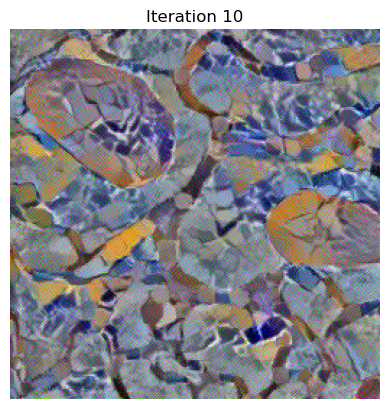

iteration 11
content_loss=100.64018249511719 style_loss=0.03247179463505745
content_loss=100.28951263427734 style_loss=0.03253970295190811
content_loss=100.15631103515625 style_loss=0.03235664591193199
content_loss=99.77902221679688 style_loss=0.03242542967200279
content_loss=99.64533996582031 style_loss=0.03224840760231018
content_loss=99.32157897949219 style_loss=0.03226988762617111
content_loss=99.19084167480469 style_loss=0.032097138464450836
content_loss=98.89657592773438 style_loss=0.03210312873125076
content_loss=98.68572998046875 style_loss=0.03202588111162186
content_loss=98.43630981445312 style_loss=0.031976114958524704
content_loss=98.24293518066406 style_loss=0.031861864030361176
content_loss=97.94007873535156 style_loss=0.03187703713774681
content_loss=97.8919448852539 style_loss=0.03164612129330635
content_loss=97.30742645263672 style_loss=0.0320291742682457
content_loss=97.42705535888672 style_loss=0.031622398644685745
content_loss=97.27986145019531 style_loss=0.03154373

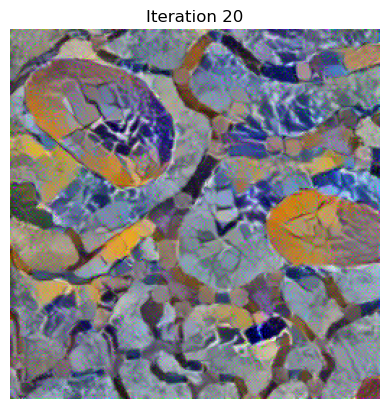

iteration 21
content_loss=77.96573638916016 style_loss=0.025833386927843094
content_loss=77.94091033935547 style_loss=0.025793056935071945
content_loss=77.8702621459961 style_loss=0.02580101415514946
content_loss=77.83395385742188 style_loss=0.02577315643429756
content_loss=77.76778411865234 style_loss=0.025777917355298996
content_loss=77.74231719970703 style_loss=0.02574354037642479
content_loss=77.67257690429688 style_loss=0.025752389803528786
content_loss=77.64291381835938 style_loss=0.02572176419198513
content_loss=77.56844329833984 style_loss=0.025736570358276367
content_loss=77.53121948242188 style_loss=0.025714412331581116
content_loss=77.4736328125 style_loss=0.025712881237268448
content_loss=77.44387817382812 style_loss=0.025682782754302025
content_loss=77.36619567871094 style_loss=0.025702601298689842
content_loss=77.36115264892578 style_loss=0.025648394599556923
content_loss=77.27532958984375 style_loss=0.025677567347884178
content_loss=77.2632064819336 style_loss=0.02563117

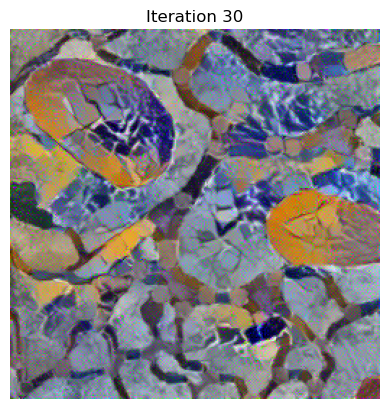

iteration 31
content_loss=71.70138549804688 style_loss=0.024146702140569687
content_loss=71.68569946289062 style_loss=0.024137718603014946
content_loss=71.66394805908203 style_loss=0.02413458749651909
content_loss=71.64141845703125 style_loss=0.024131815880537033
content_loss=71.62821960449219 style_loss=0.024119075387716293
content_loss=71.60006713867188 style_loss=0.024121854454278946
content_loss=71.59785461425781 style_loss=0.024099145084619522
content_loss=71.5682373046875 style_loss=0.02410374954342842
content_loss=71.55875396728516 style_loss=0.024088360369205475
content_loss=71.52159881591797 style_loss=0.024101480841636658
content_loss=71.5185546875 style_loss=0.02407972142100334
content_loss=71.48780822753906 style_loss=0.024085843935608864
content_loss=71.48311614990234 style_loss=0.024064861238002777
content_loss=71.45414733886719 style_loss=0.02406991645693779
content_loss=71.45036315917969 style_loss=0.024049486964941025
content_loss=71.424072265625 style_loss=0.024052035

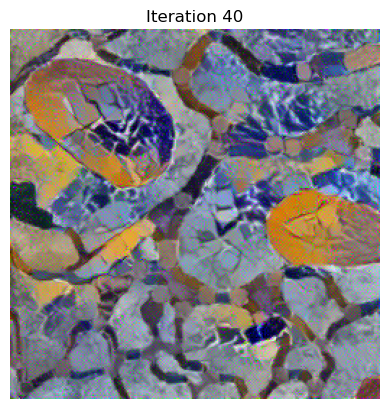

iteration 41
content_loss=68.8719482421875 style_loss=0.02326514944434166
content_loss=68.86286926269531 style_loss=0.02326144091784954
content_loss=68.85755157470703 style_loss=0.0232541561126709
content_loss=68.84443664550781 style_loss=0.023255039006471634
content_loss=68.83998107910156 style_loss=0.023246528580784798
content_loss=68.82393646240234 style_loss=0.023249924182891846
content_loss=68.82273864746094 style_loss=0.023238666355609894
content_loss=68.80467224121094 style_loss=0.023244112730026245
content_loss=68.80653381347656 style_loss=0.023230168968439102
content_loss=68.78565216064453 style_loss=0.023238521069288254
content_loss=68.78023529052734 style_loss=0.02323027327656746
content_loss=68.76614379882812 style_loss=0.023231007158756256
content_loss=68.75447845458984 style_loss=0.023230288177728653
content_loss=68.74190521240234 style_loss=0.023230547085404396
content_loss=68.73162078857422 style_loss=0.023228446021676064
content_loss=68.72077941894531 style_loss=0.0232

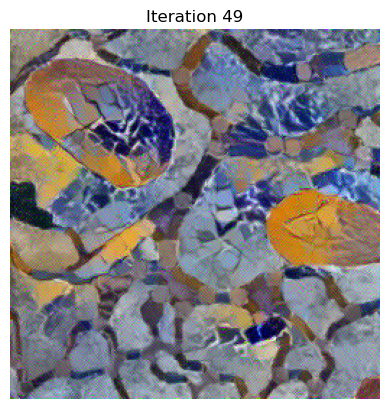

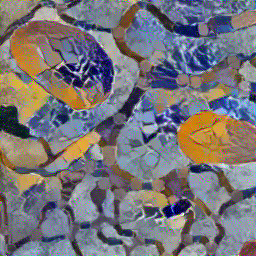

In [11]:
imarray = np.random.rand(256, 256, 3) * 255
image_in = Image.fromarray(imarray.astype("uint8")).convert("RGB")

style_transfer(
    image=image_in,
    content=content,
    style=style,
    content_layers=[model.features[l] for l in [14]],
    style_layers=[model.features[l] for l in [0, 2, 5, 7, 10]],
    lr=1,
    iter_num=50,
    beta=1e3,
)

... and using the content image as a starting point.

iteration 0
content_loss=0.0 style_loss=1.904022216796875
content_loss=2.2320807602227433e-06 style_loss=1.903765082359314
content_loss=51.435279846191406 style_loss=1.2634533643722534
content_loss=72.23223114013672 style_loss=0.875190258026123
content_loss=98.23179626464844 style_loss=0.6622881889343262
content_loss=103.97579193115234 style_loss=0.5329758524894714
content_loss=116.95336151123047 style_loss=0.42369309067726135
content_loss=140.140380859375 style_loss=0.3533737063407898
content_loss=134.3835906982422 style_loss=0.32554107904434204
content_loss=137.84530639648438 style_loss=0.29211777448654175
content_loss=144.33697509765625 style_loss=0.2580941319465637
content_loss=150.04290771484375 style_loss=0.2289465367794037
content_loss=163.8482666015625 style_loss=0.20378677546977997
content_loss=163.205810546875 style_loss=0.19055308401584625
content_loss=167.43052673339844 style_loss=0.17652687430381775
content_loss=170.26300048828125 style_loss=0.16321392357349396
content_los

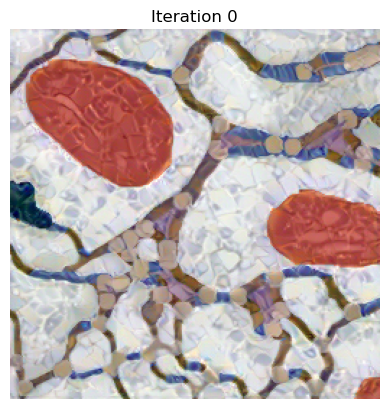

iteration 1
content_loss=197.72866821289062 style_loss=0.11005131900310516
content_loss=189.758544921875 style_loss=0.15294595062732697
content_loss=198.03128051757812 style_loss=0.10523446649312973
content_loss=199.27072143554688 style_loss=0.10302428156137466
content_loss=200.64556884765625 style_loss=0.11035380512475967
content_loss=204.73255920410156 style_loss=0.09311368316411972
content_loss=205.59144592285156 style_loss=0.09056305885314941
content_loss=206.6741943359375 style_loss=0.09434674680233002
content_loss=209.5852508544922 style_loss=0.08423985540866852
content_loss=210.67977905273438 style_loss=0.08222721517086029
content_loss=210.6769561767578 style_loss=0.09307559579610825
content_loss=215.29647827148438 style_loss=0.0754319578409195
content_loss=216.06446838378906 style_loss=0.07356297224760056
content_loss=216.21563720703125 style_loss=0.07769216597080231
content_loss=219.0170135498047 style_loss=0.06867887824773788
content_loss=219.84657287597656 style_loss=0.06714

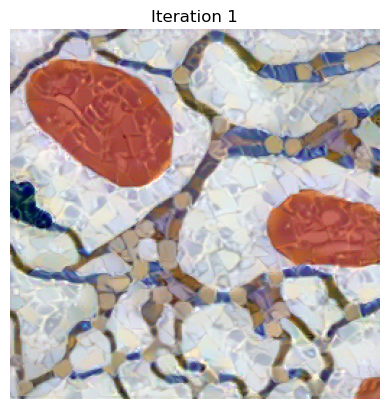

iteration 2
content_loss=226.49444580078125 style_loss=0.0572131872177124
content_loss=227.45291137695312 style_loss=0.055985379964113235
content_loss=225.1182098388672 style_loss=0.06755618751049042
content_loss=230.4300537109375 style_loss=0.052794329822063446
content_loss=230.86659240722656 style_loss=0.051667891442775726
content_loss=232.43716430664062 style_loss=0.05402224138379097
content_loss=232.43499755859375 style_loss=0.04875786602497101
content_loss=234.0880889892578 style_loss=0.04780416563153267
content_loss=235.17474365234375 style_loss=0.04729049280285835
content_loss=237.31777954101562 style_loss=0.04504551738500595
content_loss=237.7626190185547 style_loss=0.04423730447888374
content_loss=237.14125061035156 style_loss=0.04518341273069382
content_loss=239.741943359375 style_loss=0.04154614359140396
content_loss=240.07579040527344 style_loss=0.04087936133146286
content_loss=239.14031982421875 style_loss=0.0423210933804512
content_loss=241.4222869873047 style_loss=0.0393

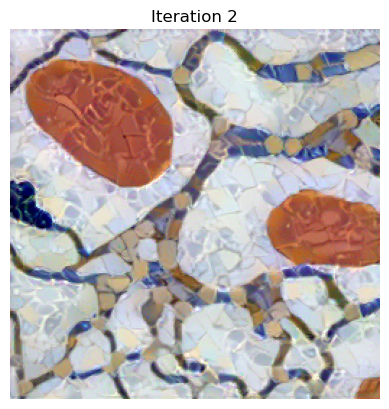

iteration 3
content_loss=242.96185302734375 style_loss=0.039659902453422546
content_loss=245.22171020507812 style_loss=0.034787800163030624
content_loss=245.4955291748047 style_loss=0.03420596942305565
content_loss=245.31375122070312 style_loss=0.03589808568358421
content_loss=246.5708465576172 style_loss=0.03279051184654236
content_loss=246.96543884277344 style_loss=0.032295115292072296
content_loss=244.97193908691406 style_loss=0.0371522530913353


In [12]:
imarray = np.random.rand(256, 256, 3) * 255
image_in = Image.fromarray(imarray.astype("uint8")).convert("RGB")

style_transfer(
    image=content,
    content=content,
    style=style,
    content_layers=[model.features[l] for l in [14]],
    style_layers=[model.features[l] for l in [0, 2, 5, 7, 10]],
    lr=1,
    iter_num=50,
    beta=1e5,
)